# Generating Hypothetical Triples Through Reasoning Paths
Query-to-Hypothetical-Triples: Deriving reasoning paths in triple form from queries for knowledge graph alignment


In [ ]:
# prompt1 = """

# Task: For a given user question, analyze it step-by-step and generate reasoning paths that meet the following conditions:

# 1. Output Format: Each step in the reasoning path should be expressed as a complete sentence. No extra explanations or context are needed.
# 2. Path Completion: Make full use of entities and relations in the original question.
# 3. Path Quantity: Generate a maximum of two distinct reasoning paths.
# 4. Dynamic Length: The length of the reasoning path should adjust according to the complexity of the question.

# Examples:

# Example 1 (Single-hop Question with one reasoning path)
# Question: "Who is the director of the movie 'Inception'?"
# Reasoning Path:
#     A person is the director of the movie 'Inception'.
# Output:
#     A director directed the movie 'Inception'.
# Example 2 (Multi-hop Question with two reasoning paths)
# Question: "What is the name of the scientist who developed the theory of general relativity and also won the Nobel Prize in Physics in 1921?"
# Reasoning Path 1:
#     The theory of general relativity was developed by a scientist.
#     The same scientist won the Nobel Prize in Physics in 1921.

# Reasoning Path 2:
#     The Nobel Prize in Physics in 1921 was awarded to a physicist.
#     That physicist also developed the theory of general relativity.

# Output:
#     The theory of general relativity was developed by a scientist.
#     The same scientist won the Nobel Prize in Physics in 1921.
#     The Nobel Prize in Physics in 1921 was awarded to a physicist.
#     That physicist also developed the theory of general relativity.
# Question: {question}
# """

In [ ]:
import pandas as pd
import logging
import time
from openai import OpenAI
import re

# Configuration
EXCEL_PATH = "../data/MSE-KG/KG_QA/Competency_Question.xlsx"
OUTPUT_EXCEL_PATH = "../data/MSE-KG/Abtest2/HypoSentences.xlsx"

# Initialize OpenAI client
client = OpenAI(api_key=API_KEY, base_url="https://api.deepseek.com")

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# New prompt template with KG structure
PROMPT_TEMPLATE = """
Task: For a given user question, analyze step-by-step and generate reasoning paths that meet the following conditions:

    1.Output Format: Multiple sentences, using natural language to express relationships.
    2.Class Constraints: Classes are allowed as bridging nodes in the path.
    3.Path Quantity: A maximum of 2 distinct reasoning paths must be generated.

Processing Guidelines:
    1.Path Completion: If a direct relation is missing, insert a class constraint as an intermediate node.
    2.Direction Control: Sentence logic must align with semantic relationships.
    3.Dynamic Length: Sentence complexity adapts to the question’s needs.
    4.Prioritization: If multiple valid paths exist, select the 2 most semantically complete and logically concise paths.

Examples

Example 1 (Single-hop Question)
Question: "Who is the director of the movie 'Inception'?"
Reasoning Path:
    The person is the director of the movie Inception.
    Inception is directed by a director.
Output:
    The person is the director of the movie Inception.
    Inception is directed by a director.

Example 2 (Multi-hop Question)
Question: "Which researcher from MIT published the dataset 'Nano2023' cited in 'Advanced Materials Lecture 5'?"
Reasoning Path:

Path 1: From MIT to Citation
    MIT has an affiliated researcher.
    The researcher published the dataset Nano2023.
    Advanced Materials Lecture 5 cites the dataset Nano2023.

Path 2: From Citation to MIT
    Advanced Materials Lecture 5 cites the dataset Nano2023.
    Nano2023 is published by MIT.
    MIT employs a researcher.

Output:
    MIT has an affiliated researcher.
    The researcher published the dataset Nano2023.
    Advanced Materials Lecture 5 cites the dataset Nano2023.
    Advanced Materials Lecture 5 cites the dataset Nano2023.
    Nano2023 is published by MIT.
    MIT employs a researcher.

Question: {question}
"""

def extract_output_section(raw_response):
    """Extract the final Output section from the response."""
    match = re.search(r'Output:\s*(.*)', raw_response, re.DOTALL)
    if match:
        return match.group(1).strip()
    return raw_response.strip()  # fallback to full content if Output not found

def generate_answer(question):
    """Generate API response with retries and extract Output section."""
    prompt = PROMPT_TEMPLATE.format(question=question)
    
    for attempt in range(3):
        try:
            response = client.chat.completions.create(
                model="deepseek-chat",
                messages=[
                    {"role": "system", "content": "You are a knowledge graph expert specialized in question reseasoning."},
                    {"role": "user", "content": prompt}],
                temperature=0.1,
                max_tokens=1024,
                seed=42
            )
            full_response = response.choices[0].message.content.strip()
            return extract_output_section(full_response)
        except Exception as e:
            logging.warning(f"Attempt {attempt+1}/3 failed: {str(e)}")
            time.sleep(1 + attempt)
    return ""

def process_questions():
    """Main processing workflow"""
    try:
        df = pd.read_excel(EXCEL_PATH, engine='openpyxl')
        questions = df.iloc[:, 0].tolist()
    except Exception as e:
        logging.error(f"Failed to read Excel file: {str(e)}")
        return

    results = []
    
    for idx, question in enumerate(questions, 1):
        logging.info(f"Processing {idx}/{len(questions)}: {question[:50]}...")
        output_text = generate_answer(question)
        print(f"Output Extracted: {output_text}")
        
        results.append({
            "Original Question": question,
            "Reasoning Path": output_text,
        })
    
    try:
        result_df = pd.DataFrame(results)
        final_df = pd.concat([df, result_df[["Reasoning Path"]]], axis=1)
        final_df.to_excel(OUTPUT_EXCEL_PATH, index=False, engine='openpyxl')
        logging.info(f"Results saved to {OUTPUT_EXCEL_PATH}")
    except Exception as e:
        logging.error(f"Failed to save results: {str(e)}")

if __name__ == "__main__":
    process_questions()


2025-05-25 21:29:55,099 - INFO - Processing 1/37: Who is working in the Computational Materials Scie...
2025-05-25 21:29:55,568 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:30:04,879 - INFO - Processing 2/37: What are the research projects associated to EMMO?...


Output Extracted: 1. Computational Materials Science is a research field.  
2. A researcher works in the field of Computational Materials Science.  
3. A researcher has expertise in a scientific discipline.  
4. The scientific discipline is Computational Materials Science.


2025-05-25 21:30:05,157 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:30:15,451 - INFO - Processing 3/37: Who are the contributors of the data "datasets"?...


Output Extracted: **  
- EMMO is a research entity. The research entity EMMO participates in research projects.  
- Research projects involve participating entities. EMMO is one of the entities associated with these projects.  

(Note: If "EMMO" refers to a specific ontology or framework, the reasoning paths could be adjusted accordingly—e.g., "EMMO is an ontology used in research projects.")


2025-05-25 21:30:15,733 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:30:27,213 - INFO - Processing 4/37: Who is working with Researcher "Ebrahim Norouzi" i...


Output Extracted: **  
1. The dataset "datasets" has contributors.  
2. The contributors are individuals or organizations involved in creating the dataset.  
3. Individuals or organizations contribute to datasets.  
4. The dataset "datasets" is one of the datasets they contribute to.


2025-05-25 21:30:27,520 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:30:38,198 - INFO - Processing 5/37: who is the email address of "ParaView"?...


Output Extracted: 1. Ebrahim Norouzi is a member of a research group.  
2. The research group has other members who work with Ebrahim Norouzi.  
3. Ebrahim Norouzi is affiliated with an academic or organizational group.  
4. The group consists of researchers who collaborate with Ebrahim Norouzi.


2025-05-25 21:30:38,477 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:30:48,179 - INFO - Processing 6/37: What are the affilliations of Volker Hofmann?...


Output Extracted: ParaView is a software application.  
    The software application has a contact email address.  
    ParaView is developed by an organization.  
    The organization provides an email address for contact.


2025-05-25 21:30:48,465 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:30:59,476 - INFO - Processing 7/37: What is "Molecular Dynamics" Software? List the pr...


Output Extracted: 1. Volker Hofmann is a person with professional affiliations that are organizations.
2. Volker Hofmann holds professional positions affiliated with certain institutions.

Note: These paths are structured to accommodate potential missing direct relationships by using "professional affiliations" and "professional positions" as bridging classes. The actual answer would require specific knowledge about Hofmann's career, but these paths provide the logical framework to reach that information.


2025-05-25 21:31:00,390 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:31:12,976 - INFO - Processing 8/37: What are pre- and post-processing tools for MD sim...


Output Extracted: 1. "Molecular Dynamics" is a software tool.  
2. The software is implemented in one or more programming languages.  
3. The software has official documentation available on a webpage.  
4. The software's source code is hosted in a repository.  
5. The software is distributed under a specific license.  
6. The documentation page describes "Molecular Dynamics" software.  
7. The documentation references the programming languages used.  
8. The documentation links to the software's repository.  
9. The documentation specifies the software's license.


2025-05-25 21:31:13,299 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:31:25,485 - INFO - Processing 9/37: What are some workflow environments for computatio...


Output Extracted: Molecular dynamics (MD) simulations require pre-processing tools.  
Pre-processing tools prepare input files for MD simulations.  
MD simulations also utilize post-processing tools.  
Post-processing tools analyze the output data from MD simulations.  
Pre-processing tools are used in computational chemistry workflows.  
These tools specifically support MD simulations.  
Post-processing tools are part of the MD simulation pipeline.  
They interpret results generated by MD simulations.


2025-05-25 21:31:25,892 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:31:34,291 - INFO - Processing 10/37: How should I cite pyiron?...


Output Extracted: Computational materials science utilizes workflow environments for simulations.  
These workflow environments are specialized software platforms designed for materials science research.  
Workflow environments support scientific computing tasks.  
Some workflow environments are specifically adapted for computational materials science applications.


2025-05-25 21:31:34,593 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:31:43,714 - INFO - Processing 11/37: Where can I find a list of interatomic potentials?...


Output Extracted: Pyiron is a software project that has a recommended citation format, which can be found in its documentation.
    Pyiron's documentation contains citation instructions that specify how to properly cite the software.


2025-05-25 21:31:44,002 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:31:54,870 - INFO - Processing 12/37: What are python libraries used for calculating loc...


Output Extracted: 1. A materials science database contains computational resources.  
2. Interatomic potentials are a type of computational resource.  
3. The database provides a list of interatomic potentials.  
4. A research repository hosts simulation tools and datasets.  
5. Interatomic potentials are categorized as simulation tools.  
6. The repository's documentation includes a list of interatomic potentials.


2025-05-25 21:31:55,159 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:32:06,547 - INFO - Processing 13/37: What are the electronic lab notebooks available?...


Output Extracted: 1. Calculating local atomic structural environments is a computational chemistry task.  
2. Python libraries provide functions for computational chemistry tasks.  
3. Specific Python libraries exist for calculating local atomic structural environments.  
4. Materials science and computational chemistry involve analyzing atomic structures.  
5. Python is a programming language used in scientific computing for these domains.  
6. Python libraries are developed to calculate local atomic structural environments in these fields.


2025-05-25 21:32:06,830 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:32:16,478 - INFO - Processing 14/37: What are the software for Molecular Dynamics (MD)?...


Output Extracted: Electronic lab notebooks belong to the category of scientific software.  
    Scientific software includes specific products like LabArchives and Benchling.  
    Research laboratories use digital documentation tools.  
    Digital documentation tools include electronic lab notebooks such as eLabJournal and SciNote.


2025-05-25 21:32:17,305 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:32:26,802 - INFO - Processing 15/37: What are the ontologies in nanomaterials domain?...


Output Extracted: **  
1. Molecular Dynamics (MD) is a computational method.  
2. The computational method is implemented by software tools.  
3. Software tools are designed for specific applications.  
4. One application of these tools is Molecular Dynamics (MD).


2025-05-25 21:32:27,266 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:32:39,005 - INFO - Processing 16/37: What is DAMASK?...


Output Extracted: - The nanomaterials domain is a specialized field of study.
- This domain utilizes ontologies for knowledge representation.
- Ontologies in this domain describe nanomaterials concepts and relationships.
- An ontology is a formal knowledge representation system.
- Some ontologies are specifically designed for scientific domains.
- The nanomaterials domain has several developed ontologies for classification purposes.


2025-05-25 21:32:39,298 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:32:48,227 - INFO - Processing 17/37: What are the data portals for materials science on...


Output Extracted: - DAMASK is a software tool used in materials science.  
- The tool simulates crystal plasticity at the microstructural level.  
- DAMASK belongs to the class of computational materials modeling tools.  
- It enables researchers to predict material behavior under mechanical deformation.


2025-05-25 21:32:48,509 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:32:57,544 - INFO - Processing 18/37: What are the instruments for APT?...


Output Extracted: **  
1. Materials science is a domain that utilizes ontologies.  
   Ontologies in materials science are accessible through data portals.  
2. Ontologies are structured knowledge representations.  
   Materials science ontologies are hosted on domain-specific data portals.


2025-05-25 21:32:57,848 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:33:08,299 - INFO - Processing 19/37: In which institution can I find tomography equipme...


Output Extracted: - APT (Advanced Persistent Threat) is a type of cyberattack that utilizes various hacking tools and techniques as instruments.
- Security professionals use specialized instruments including network monitoring tools and forensic analysis software to detect APT activities.


2025-05-25 21:33:08,706 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:33:16,075 - INFO - Processing 20/37: What are the educational resources for Ontology?...


Output Extracted: Tomography equipment is a type of scientific instrument.  
Scientific instruments are typically housed in research institutions.  
Research institutions often maintain imaging facilities.  
Imaging facilities contain tomography equipment.


2025-05-25 21:33:16,385 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:33:27,954 - INFO - Processing 21/37: What is the API of Materials Project?...


Output Extracted: - Ontology is a subject of study.  
- Educational resources exist for subjects of study.  
- These resources cover Ontology.  
- Educational resources include materials for various subjects.  
- Ontology is one of the subjects covered by these resources.


2025-05-25 21:33:28,262 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:33:39,834 - INFO - Processing 22/37: Which simulation software have a python API?...


Output Extracted: Materials Project is a scientific database project.
    The project provides an application programming interface (API).
    The API allows programmatic access to Materials Project's data.
    Materials Project offers data access services.
    These services are implemented through an API.
    The API specifies how to interact with Materials Project's systems.


2025-05-25 21:33:40,127 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:33:49,605 - INFO - Processing 23/37: What is the documentation of the "MatDB Online"?...


Output Extracted: 1. Simulation software is a type of computer program.  
2. The computer program provides a Python API as an interface.  
3. A Python API is an interface for software interaction.  
4. The interface is provided by simulation software.


2025-05-25 21:33:49,900 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:33:59,599 - INFO - Processing 24/37: What are the types of software licenses?...


Output Extracted: - MatDB Online is a database system.
- The database system has associated documentation.
- The documentation describes MatDB Online's features and usage.
- There exists documentation for database systems.
- MatDB Online is an instance of a database system.
- The documentation explains MatDB Online's functionality.


2025-05-25 21:33:59,885 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:34:09,242 - INFO - Processing 25/37: What are the software used to produce the data in ...


Output Extracted: 1. Software is governed by licenses.  
2. Licenses have different types.  
3. Software licenses belong to broader categories (e.g., proprietary, open-source).  
4. Each category includes specific license types (e.g., GPL, MIT, Apache).


2025-05-25 21:34:09,525 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:34:22,033 - INFO - Processing 26/37: What are datasets produced by the BAM organization...


Output Extracted: 1. The Materials Cloud repository contains scientific datasets.  
2. These datasets are produced using specific software tools.  
3. The software tools are used for data generation or analysis in materials science.  
4. Scientific data in materials science is generated using computational or experimental software.  
5. The resulting datasets are stored in the Materials Cloud repository.  
6. The repository documents the software used for data production.


2025-05-25 21:34:22,880 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:34:32,263 - INFO - Processing 27/37: What are some available datasets of mechanical pro...


Output Extracted: **  
1. The BAM organization is a research or data-producing entity.  
2. The BAM organization produces datasets as part of its activities.  
3. Datasets are created by research organizations.  
4. The BAM organization is one such organization that creates datasets.


2025-05-25 21:34:32,671 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:34:43,225 - INFO - Processing 28/37: What are datasets related to "Transmission electro...


Output Extracted: 1. Steel is a class of materials with mechanical properties.  
2. Datasets exist that document mechanical properties of materials.  
3. Some datasets specifically focus on mechanical properties of steels.  
4. Materials science research involves studying mechanical properties.  
5. Steel is a key material in this research domain.  
6. Researchers compile datasets of mechanical properties for steels.


2025-05-25 21:34:43,529 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:34:58,065 - INFO - Processing 29/37: What is the license of the dataset "Elastic Consta...


Output Extracted: - Transmission electron microscopy is a microscopy technique.  
- Microscopy techniques are used to generate experimental datasets.  
- Experimental datasets include those related to transmission electron microscopy.  
- Transmission electron microscopy is a method used in materials science research.  
- Materials science research produces datasets categorized by analytical techniques.  
- These datasets may be labeled with "transmission electron microscopy" as a keyword.  

*Note: Class constraints (e.g., "microscopy technique", "materials science research") bridge gaps where direct dataset relations might not exist.*


2025-05-25 21:34:58,374 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:35:10,361 - INFO - Processing 30/37: What is the repository for "BAM reference data"?...


Output Extracted: 1. The dataset "Elastic Constant Demo Data" has a license.  
2. A license governs the usage terms of the dataset "Elastic Constant Demo Data".  
3. "Elastic Constant Demo Data" is an instance of a dataset.  
4. A dataset has a license as one of its metadata properties.  

*Note: Path 1 assumes a direct relationship, while Path 2 uses the class "dataset" as a bridging node to infer the license property.*


2025-05-25 21:35:10,665 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:35:21,316 - INFO - Processing 31/37: What are the different data formats in the "BAM re...


Output Extracted: **  
1. "BAM reference data" is a type of dataset.  
   The dataset is stored in a repository.  
2. A repository contains reference datasets.  
   "BAM reference data" is one such dataset in the repository.  

These paths logically connect the dataset to its repository while maintaining semantic clarity.


2025-05-25 21:35:21,601 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:35:30,356 - INFO - Processing 32/37: What is the software version of "pacemaker"?...


Output Extracted: 1. "BAM reference data" is a dataset that contains information.
2. The dataset stores its information in specific data formats.
3. "BAM reference data" belongs to the category of reference datasets.
4. Reference datasets typically document their supported data formats in their specifications.


2025-05-25 21:35:30,655 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:35:40,779 - INFO - Processing 33/37: What is the field of research "BAM reference data"...


Output Extracted: **  
1. "Pacemaker" is a software application.  
2. The software application has a version number.  
3. A version number is associated with software.  
4. The software named "pacemaker" has a specific version.


2025-05-25 21:35:41,183 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:35:51,717 - INFO - Processing 34/37: What is the description of the "BAM reference data...


Output Extracted: 1. "BAM reference data" is a dataset used in research.  
2. The dataset belongs to a specific research field.  
3. A research field involves the use of datasets.  
4. "BAM reference data" is classified under one such research field.  

These paths infer that the dataset is linked to a broader research domain, though the exact field would require additional knowledge.


2025-05-25 21:35:52,595 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:36:01,646 - INFO - Processing 35/37: What are the datasets produced in 2022?...


Output Extracted: BAM reference data is a type of genomic dataset.
    The genomic dataset has a specific description as its metadata.
    BAM reference data is used in bioinformatics analyses.
    Bioinformatics analyses require reference data with documented descriptions.


2025-05-25 21:36:01,971 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:36:11,923 - INFO - Processing 36/37: Who is the creators of the "BAM reference data"?...


Output Extracted: 1. The year 2022 is a temporal attribute of datasets.  
   Datasets produced in 2022 have a publication date in that year.  
2. A dataset is a research output with a publication year.  
   The publication year of the dataset is 2022.


2025-05-25 21:36:12,210 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:36:22,965 - INFO - Processing 37/37: What are the datasets published by "BAM"?...


Output Extracted: 1. The "BAM reference data" is a dataset.  
2. A dataset has creators.  
3. The creators are associated with the "BAM reference data".  
4. A creator is a person or organization.  
5. The creator produces datasets.  
6. The "BAM reference data" is one such dataset created by them.


2025-05-25 21:36:23,258 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:36:32,047 - INFO - Results saved to ../data/MSE-KG/Abtest2/HypoSentences.xlsx


Output Extracted: **  
1. BAM is an organization that conducts research.  
2. The organization BAM has published multiple datasets.  
3. A dataset is a research output.  
4. The datasets are published by the organization BAM.


# Constructing an Offline Vector Database for Embedded Triples

In [ ]:
import numpy as np
import faiss
import json
import logging
from sentence_transformers import SentenceTransformer

TRIPLES_PATH = "../data/MSE-KG/KGPreprocess/verbalized_triples_np.txt"
INDEX_PATH = "../data/MSE-KG/Abtest2/Faiss_Index_S.index"
META_PATH = "../data/MSE-KG/Abtest2/FactualTriples_S.json"

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def build_vector_db():
    """Build a vector database from knowledge graph triples in sentence form"""
    # Load sentence-form triples
    with open(TRIPLES_PATH, 'r', encoding='utf-8') as f:
        valid_triples = [line.strip() for line in f if line.strip()]
    
    # Generate embeddings
    model = SentenceTransformer("BAAI/bge-m3")
    embeddings = model.encode(valid_triples, convert_to_tensor=False)
    embeddings = np.array(embeddings).astype("float32")

    # Create FAISS index
    index = faiss.IndexFlatIP(embeddings.shape[1])
    index.add(embeddings)
    
    # Save index and metadata
    faiss.write_index(index, INDEX_PATH)
    with open(META_PATH, 'w') as f:
        json.dump({"triples": valid_triples}, f)
    
    logging.info(f"Successfully built index! Saved to: {INDEX_PATH}")

if __name__ == "__main__":
    build_vector_db()


2025-05-23 08:20:48,832 - INFO - Loading faiss with AVX512 support.
2025-05-23 08:20:48,837 - INFO - Could not load library with AVX512 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx512'")
2025-05-23 08:20:48,837 - INFO - Loading faiss with AVX2 support.
2025-05-23 08:20:48,957 - INFO - Successfully loaded faiss with AVX2 support.
2025-05-23 08:20:57,708 - INFO - PyTorch version 2.5.1 available.
2025-05-23 08:20:58,423 - INFO - Use pytorch device_name: cpu
2025-05-23 08:20:58,424 - INFO - Load pretrained SentenceTransformer: BAAI/bge-m3


Batches:   0%|          | 0/162 [00:00<?, ?it/s]

2025-05-23 08:34:02,892 - INFO - Successfully built index! Saved to: ../data/MSE-KG/Faiss_Index_S.index


# Online Alignment of Hypothetical and Factual Triplets in Vector Space

In [4]:
# Core Steps!
import pandas as pd
import numpy as np
import faiss
import json
import os
import logging
import re
from sentence_transformers import SentenceTransformer

INDEX_PATH = "../data/MSE-KG/Abtest2/Faiss_Index_S.index"
META_PATH = "../data/MSE-KG/Abtest2/FactualTriples_S.json"
INPUT_EXCEL = "../data/MSE-KG/Abtest2/HypoSentences.xlsx"
OUTPUT_EXCEL = "../data/MSE-KG/Abtest2/Factual_Senetence.xlsx"

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

class SentenceMatcher:
    def __init__(self):
        """Initialize the sentence matcher with FAISS index and metadata"""
        self.index = faiss.read_index(INDEX_PATH)
        with open(META_PATH) as f:
            self.metadata = json.load(f)["triples"]
        self.model = SentenceTransformer("BAAI/bge-m3", device='cpu')
    
    def clean_sentence(self, sentence):
        """Clean and normalize a single sentence"""
        # Remove extra whitespace and quotes
        sentence = re.sub(r'^"|"$', '', sentence.strip())
        # Normalize whitespace
        sentence = ' '.join(sentence.split())
        return sentence
    
    def parse_input_sentences(self, raw_str):
        """Parse reasoning path text into clean individual sentences"""
        if pd.isna(raw_str) or "#VALUE!" in str(raw_str):
            return []
        
        # Handle both quoted multi-line strings and direct strings
        if isinstance(raw_str, str):
            # Remove outer quotes if present
            if raw_str.startswith('"') and raw_str.endswith('"'):
                raw_str = raw_str[1:-1]
            
            # Split by newlines and clean each line
            sentences = [self.clean_sentence(s) for s in raw_str.split('\n') if s.strip()]
            return sentences
        
        return []
    
    def search_similar(self, query_text, top_k=100):
        """Similarity search with error handling"""
        try:
            query_embed = self.model.encode(query_text, 
                                         convert_to_tensor=False, 
                                         show_progress_bar=False)
            query_embed = np.array(query_embed).astype("float32").reshape(1, -1)
            scores, indices = self.index.search(query_embed, top_k)
            return [
                {"sentence": self.metadata[i], "score": float(s)}
                for i, s in zip(indices[0], scores[0])
                if i < len(self.metadata)  # Ensure index is within bounds
            ]
        except Exception as e:
            logging.error(f"Search failed: {query_text} | Error: {str(e)}")
            return []
    
    def format_results(self, matches):
        """Format the search results for output"""
        formatted = []
        seen = set()  # To avoid duplicates
        
        for m in matches:
            sentence = m["sentence"]
            if sentence not in seen:  # Only add unique sentences
                seen.add(sentence)
                formatted.append(f"{sentence} (Score: {m['score']:.2f})")
        
        return formatted

def main():
    """Main execution function"""
    matcher = SentenceMatcher()
    top_k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

    df_original = pd.read_excel(INPUT_EXCEL)

    for top_k in top_k_list:
        df = df_original.copy()
        results = []

        for idx, row in df.iterrows():
            raw_text = row["Reasoning Path"]
            sentences = matcher.parse_input_sentences(raw_text)

            all_matches = []
            for sentence in sentences:
                matches = matcher.search_similar(sentence, top_k=top_k)
                formatted_matches = matcher.format_results(matches)
                all_matches.extend(formatted_matches)

            # Sort matches by score in descending order
            all_matches_sorted = sorted(
                all_matches,
                key=lambda x: float(re.search(r"Score: (\d+\.\d+)", x).group(1)),
                reverse=True
            )
            
            results.append("\n".join(all_matches_sorted) if all_matches_sorted else "#VALUE!")

        df["Factual Sentences"] = results
        output_file = OUTPUT_EXCEL.replace(".xlsx", f"_top{top_k}.xlsx")
        df.to_excel(output_file, index=False)
        logging.info(f"top_k={top_k} processing completed! Results saved to {output_file}")

if __name__ == "__main__":
    main()

2025-05-25 21:37:21,803 - INFO - Loading faiss with AVX512 support.
2025-05-25 21:37:21,803 - INFO - Could not load library with AVX512 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx512'")
2025-05-25 21:37:21,803 - INFO - Loading faiss with AVX2 support.
2025-05-25 21:37:21,893 - INFO - Successfully loaded faiss with AVX2 support.
2025-05-25 21:37:33,466 - INFO - PyTorch version 2.5.1 available.
2025-05-25 21:37:34,372 - INFO - Load pretrained SentenceTransformer: BAAI/bge-m3
2025-05-25 21:38:48,962 - INFO - top_k=10 processing completed! Results saved to ../data/MSE-KG/Abtest2/Factual_Senetence_top10.xlsx
2025-05-25 21:40:13,453 - INFO - top_k=20 processing completed! Results saved to ../data/MSE-KG/Abtest2/Factual_Senetence_top20.xlsx
2025-05-25 21:41:13,211 - INFO - top_k=30 processing completed! Results saved to ../data/MSE-KG/Abtest2/Factual_Senetence_top30.xlsx
2025-05-25 21:41:50,989 - INFO - top_k=40 processing completed! Results saved to ../data/MSE-

In [6]:
# Processing the top_k versions of the triples
import os
BASE_INPUT_PATH = "../data/MSE-KG/Abtest2/Factual_Senetence_top"
OUTPUT_DIR = "../data/MSE-KG/Abtest2/"
TOP_K_LIST = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
TARGET_COLUMN = "Factual Sentences"
OUTPUT_COLUMN = "Matched Sentences"

def clean_possible_triples(text):
    if pd.isna(text):
        return ""

    cleaned_lines = []
    for line in str(text).strip().splitlines():
        line = re.sub(r'\s*\(Score:\s*\d+\.\d+\)', '', line)
        cleaned_lines.append(line)

    return '\n'.join(cleaned_lines)


def process_excel_file(input_path, output_path):
    """Process Excel file: clean triples and save to new file"""
    df = pd.read_excel(input_path, engine='openpyxl')
    df[OUTPUT_COLUMN] = df[TARGET_COLUMN].apply(clean_possible_triples)
    df.to_excel(output_path, index=False, engine='openpyxl')
    print(f"Processing completed: {output_path}")

# Main execution: process multiple top_k versions
for top_k in TOP_K_LIST:
    input_path = f"{BASE_INPUT_PATH}{top_k}.xlsx"
    output_path = os.path.join(OUTPUT_DIR, f"Factual_Senetence_top{top_k}_cleaned.xlsx")
    process_excel_file(input_path, output_path)

Processing completed: ../data/MSE-KG/Abtest2/Factual_Senetence_top10_cleaned.xlsx
Processing completed: ../data/MSE-KG/Abtest2/Factual_Senetence_top20_cleaned.xlsx
Processing completed: ../data/MSE-KG/Abtest2/Factual_Senetence_top30_cleaned.xlsx
Processing completed: ../data/MSE-KG/Abtest2/Factual_Senetence_top40_cleaned.xlsx
Processing completed: ../data/MSE-KG/Abtest2/Factual_Senetence_top50_cleaned.xlsx
Processing completed: ../data/MSE-KG/Abtest2/Factual_Senetence_top60_cleaned.xlsx
Processing completed: ../data/MSE-KG/Abtest2/Factual_Senetence_top70_cleaned.xlsx
Processing completed: ../data/MSE-KG/Abtest2/Factual_Senetence_top80_cleaned.xlsx
Processing completed: ../data/MSE-KG/Abtest2/Factual_Senetence_top90_cleaned.xlsx
Processing completed: ../data/MSE-KG/Abtest2/Factual_Senetence_top100_cleaned.xlsx


# Denoising and Reranking

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from openai import OpenAI
import pandas as pd
import time
import os
from tqdm import tqdm
from threading import Semaphore

# 配置常量
BASE_URL = "https://api.deepseek.com"
MODEL_NAME = "deepseek-chat"
MAX_TOKENS = 1024
MAX_WORKERS = 3
MAX_API_CONCURRENT = 5
DATA_DIR = "../data/MSE-KG/Abtest2/"
INPUT_FILE = "Factual_Senetence_top{}_cleaned.xlsx"  # 确保输入文件包含句子列
RETRY_COUNT = 3
OUTPUT_TEMPLATE = "Contexts_Factual_Senetence_top{}.xlsx"

# 更新后的提示词（适配句子过滤）
RERANK_PROMPT = """
Filter relevant sentences from the provided list based on a user's question. Return only filtered sentences in plain text. Do not include introductions, explanations, or scoring details. Output must consist solely of clean sentences.

[Input]
# Target Question: {competency_question}
# Candidate Sentences:{matched_sentences}

Filtering Rules

1. Direct Match:
    - Sentence explicitly mentions key entities from the question
    - Contains direct relationship matching question intent

2. Indirect Match:
    - Provides supporting context through related entities/concepts
    - Contains inferable information relevant to the question

Scoring Criteria

1. Directness: 2 = direct mention, 1 = indirect reference
2. Entity Clarity: 2 = explicit entities, 1 = ambiguous references
3. Context Relevance: 2 = core relevance, 1 = peripheral relevance

Filtering Conditions
 Keep only sentences with total score ≥ 3
 Exclude sentences with ambiguous references or low information density

Output Format
Only output filtered sentences, one per line.
No extra text.

Example
Input
Target Question: Who was the first president of the United States?

Candidate Sentences:
    George Washington was the first president of the United States.
    Thomas Jefferson drafted the Declaration of Independence.
    The U.S. Constitution was ratified in 1788.
    George Washington took office in 1789.
    John Adams was the second president of the United States.
    The presidency was established after the American Revolution.
    The capital city was later named Washington, D.C. in his honor.
    He remains a symbol of American independence.

Output
    George Washington was the first president of the United States.
    George Washington took office in 1789.
"""

api_semaphore = Semaphore(MAX_API_CONCURRENT)
client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

def rerank_sentences(question: str, sentences: str) -> str:
    if not isinstance(question, str) or not isinstance(sentences, str):
        return "[Invalid input: Non-string question or sentences]"

    prompt = RERANK_PROMPT.format(
        competency_question=question.strip(),
        matched_sentences=sentences.strip()
    )

    with api_semaphore:
        for attempt in range(RETRY_COUNT):
            try:
                response = client.chat.completions.create(
                    model=MODEL_NAME,
                    messages=[{"role": "user", "content": prompt}],
                    max_tokens=MAX_TOKENS
                )
                return response.choices[0].message.content.strip()
            except Exception:
                time.sleep(2 ** attempt)
    return "[API Error: Maximum retries exceeded]"

def process_subset(n: int):
    input_path = os.path.join(DATA_DIR, INPUT_FILE.format(n))
    df = pd.read_excel(input_path)

    # 列名验证
    required_columns = ['Competency Question', 'Matched Sentences']  # 修改列名
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise KeyError(f"Missing required columns: {missing_cols}")

    contexts = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Processing top {n}"):
        question = row['Competency Question']
        sentences = row['Matched Sentences']  # 修改列名
        context = rerank_sentences(question, sentences)
        contexts.append(context)

    df['Contexts'] = contexts
    output_path = os.path.join(DATA_DIR, OUTPUT_TEMPLATE.format(n))
    df.to_excel(output_path, index=False)
    print(f"Saved top-{n} reranked contexts to {output_path}")

def main():
    subset_sizes = list(range(10, 31, 10))  # 40, 50, ..., 100
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        executor.map(process_subset, subset_sizes)

if __name__ == '__main__':
    main()

Processing top 10:   0%|          | 0/37 [00:00<?, ?it/s]
2025-05-25 21:49:21,731 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:49:21,731 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:49:21,731 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
Processing top 10:   3%|▎         | 1/37 [00:07<04:27,  7.42s/it]2025-05-25 21:49:28,899 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:49:32,996 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:49:36,653 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
Processing top 10:   5%|▌         | 2/37 [00:22<07:00, 12.02s/it]2025-05-25 21:49:44,050 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:49:49,377 - I

Saved top-10 reranked contexts to ../data/MSE-KG/Abtest2/Contexts_Factual_Senetence_top10.xlsx



2025-05-25 21:55:42,298 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:55:44,841 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:55:50,763 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:55:51,067 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:55:59,157 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:56:03,764 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:56:10,419 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:56:11,034 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 21:56:24,848 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1

Saved top-20 reranked contexts to ../data/MSE-KG/Abtest2/Contexts_Factual_Senetence_top20.xlsx



2025-05-25 21:57:13,486 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:57:42,476 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:57:50,569 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:57:58,457 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:58:05,414 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:58:11,046 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:58:20,264 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:58:38,501 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"

2025-05-25 21:58:49,760 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "

Saved top-30 reranked contexts to ../data/MSE-KG/Abtest2/Contexts_Factual_Senetence_top30.xlsx


# Generation

In [ ]:
GENRATION_PROMPT_TEMPLATE = '''
Given the following question and corresponding factual contexts in triples format:

Question: {question}
Context(s): {contexts}
Instructions:
1. Use Contexts Effectively: While the contexts provide information, they may contain redundancy. Focus on the most relevant triples that directly answer the question.
2. Leverage Understanding: Utilize your ability to comprehend and deduce the most essential details, even if some triples are less relevant or repetitive.
3. Direct Answers: Provide answers in a list format of phrases if appropriate, without any introductory phrases or complete sentences. Only provide the key facts.
4. Avoid Irrelevant Details: Omit information that does not directly contribute to answering the question.
5. List Format: When listing items, separate them with semicolons (;) instead of using dashes (-) or other symbols.
6. No Prefixes: Do not include any introductory phrases like "Based on the provided contexts" or "Answer:".
7. No Answer Indication: If no relevant information is found, simply return "(No Answer)" without any additional explanation.

Examples:

Question: Who was the first president of the United States?
Context: 
    George Washington was the first president of the United States.
    Thomas Jefferson was the author of the Declaration of Independence.
    George Washington took office in 1789.
    John Adams was the second president of the United States.
Answer:
George Washington.

'''

In [ ]:
from openai import OpenAI
import pandas as pd
import time
import logging
import os
from tqdm import tqdm

GENRATION_PROMPT_TEMPLATE = '''
Given the following question and corresponding factual contexts in triples format:

Question: {question}
Context(s): {contexts}
Instructions:
1. Use Contexts Effectively: While the contexts provide information, they may contain redundancy. Focus on the most relevant triples that directly answer the question.
2. Leverage Understanding: Utilize your ability to comprehend and deduce the most essential details, even if some triples are less relevant or repetitive.
3. Direct Answers: Provide answers in a list format of phrases if appropriate, without any introductory phrases or complete sentences. Only provide the key facts.
4. Avoid Irrelevant Details: Omit information that does not directly contribute to answering the question.
5. List Format: When listing items, separate them with semicolons (;) instead of using dashes (-) or other symbols.
6. No Prefixes: Do not include any introductory phrases like "Based on the provided contexts" or "Answer:".
7. No Answer Indication: If no relevant information is found, simply return "(No Answer)" without any additional explanation.

Examples:

Question: Who was the first president of the United States?
Context: 
    George Washington was the first president of the United States.
    Thomas Jefferson was the author of the Declaration of Independence.
    George Washington took office in 1789.
    John Adams was the second president of the United States.
Answer:
George Washington.

'''

# Configuration Constants
BASE_URL = "https://api.deepseek.com"
MODEL_NAME = "deepseek-chat"
MAX_TOKENS = 1024
RETRY_COUNT = 3
SLEEP_INTERVAL = 1  # Rate limiting between API calls
DATA_DIR = "../data/MSE-KG/Abtest2/"
LOG_PATH = '../log/test.log'

# Set up logging
logging.basicConfig(
    filename=LOG_PATH,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

def generate_answer(question: str, context: str) -> str:
    """Generates answer using OpenAI API with retry mechanism."""
    if not context.strip():
        return "[No relevant context found]"

    prompt = GENRATION_PROMPT_TEMPLATE.format(question=question, contexts=context)
    
    for attempt in range(RETRY_COUNT):
        try:
            response = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=MAX_TOKENS
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            logging.warning(f"API error (Attempt {attempt+1}/{RETRY_COUNT}): {str(e)}")
            time.sleep(2 ** attempt)  # Exponential backoff
    return "[API Error: Maximum retries exceeded]"

def process_questions(df: pd.DataFrame) -> tuple[list, list]:
    """Processes dataframe rows and generates answers."""
    answers = []
    failed_indices = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Answers"):
        try:
            question = str(row.get('Competency Question', ''))
            context = str(row.get('Contexts', ''))
            answer = generate_answer(question, context)
            answers.append(answer)

            if index % 10 == 0:
                logging.info(f"Processed {index+1}/{len(df)}")

            time.sleep(SLEEP_INTERVAL)  # Global rate limiting
        except Exception as e:
            logging.error(f"Row {index} failed: {str(e)}")
            answers.append("[Error]")
            failed_indices.append(index)

    return answers, failed_indices

def process_single_file(input_path,output_path):

    try:
        df = pd.read_excel(input_path)
        
        # Validate and rename columns
        required_columns = ['Competency Question', 'Ground Truth', 'Contexts']
        if not all(col in df.columns for col in required_columns):
            df.columns = required_columns[:len(df.columns)]

        logging.info(f"Processing: {input_path}")
        answers, failed = process_questions(df)

        df['Answer'] = answers
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df.to_excel(output_path, index=False)
        
        logging.info(f"Saved answers to {output_path}")
        print(f"[✓] Saved: {output_path}")
        if failed:
            logging.warning(f"Failed rows in {input_path}: {len(failed)}")
            print(f"[-] {len(failed)} rows failed in {input_path}")

    except Exception as e:
        logging.error(f"Error processing {input_path}: {str(e)}")
        print(f"[X] Error with file {input_path}: {str(e)}")

if __name__ == "__main__":
    for i in range(10, 51, 10):
        input_path = f"{DATA_DIR}Contexts_Factual_Senetence_top{i}.xlsx"
        output_path = f"{DATA_DIR}Predicted_Answers_Contexts_Factual_Senetence_top{i}.xlsx"
        process_single_file(input_path, output_path)


2025-05-25 22:11:04,581 - INFO - Processing: ../data/MSE-KG/Abtest2/Contexts_Factual_Senetence_top10.xlsx
Generating Answers:   0%|          | 0/37 [00:00<?, ?it/s]2025-05-25 22:11:05,314 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:11:10,328 - INFO - Processed 1/37
Generating Answers:  27%|██▋       | 10/37 [01:16<03:44,  8.30s/it]2025-05-25 22:12:21,087 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:12:25,182 - INFO - Processed 11/37
Generating Answers:  54%|█████▍    | 20/37 [02:21<02:04,  7.34s/it]2025-05-25 22:13:26,054 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:13:30,653 - INFO - Processed 21/37
Generating Answers:  81%|████████  | 30/37 [03:26<00:42,  6.07s/it]2025-05-25 22:14:31,830 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:14:35,544 - INFO - Processe

[✓] Saved: ../data/MSE-KG/Abtest2/Predicted_Answers_Contexts_Factual_Senetence_top10.xlsx


Generating Answers:   0%|          | 0/37 [00:00<?, ?it/s]2025-05-25 22:15:14,352 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:15:19,881 - INFO - Processed 1/37
Generating Answers:  27%|██▋       | 10/37 [01:12<03:35,  7.98s/it]2025-05-25 22:16:27,165 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:16:35,460 - INFO - Processed 11/37
Generating Answers:  54%|█████▍    | 20/37 [02:34<02:27,  8.68s/it]2025-05-25 22:17:48,473 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:17:52,650 - INFO - Processed 21/37
Generating Answers:  81%|████████  | 30/37 [03:48<00:49,  7.02s/it]2025-05-25 22:19:02,610 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:19:07,934 - INFO - Processed 31/37
Generating Answers: 100%|██████████| 37/37 [04:36<00:00,  7.46s/it]
2025-05-25 22:19:50,402 - INFO

[✓] Saved: ../data/MSE-KG/Abtest2/Predicted_Answers_Contexts_Factual_Senetence_top20.xlsx


Generating Answers:   0%|          | 0/37 [00:00<?, ?it/s]2025-05-25 22:19:50,802 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:19:57,604 - INFO - Processed 1/37
Generating Answers:  27%|██▋       | 10/37 [01:15<03:21,  7.47s/it]2025-05-25 22:21:06,137 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:21:10,508 - INFO - Processed 11/37
Generating Answers:  54%|█████▍    | 20/37 [02:33<02:18,  8.16s/it]2025-05-25 22:22:24,136 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:22:28,333 - INFO - Processed 21/37
Generating Answers:  81%|████████  | 30/37 [03:55<00:51,  7.34s/it]2025-05-25 22:23:46,165 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:23:50,467 - INFO - Processed 31/37
Generating Answers: 100%|██████████| 37/37 [04:42<00:00,  7.63s/it]
2025-05-25 22:24:32,930 - INFO

[✓] Saved: ../data/MSE-KG/Abtest2/Predicted_Answers_Contexts_Factual_Senetence_top30.xlsx


Generating Answers:   0%|          | 0/37 [00:00<?, ?it/s]2025-05-25 22:24:33,373 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:24:38,897 - INFO - Processed 1/37
Generating Answers:  27%|██▋       | 10/37 [01:23<04:00,  8.92s/it]2025-05-25 22:25:56,785 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:26:04,592 - INFO - Processed 11/37
Generating Answers:  54%|█████▍    | 20/37 [02:40<02:25,  8.57s/it]2025-05-25 22:27:13,632 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:27:17,319 - INFO - Processed 21/37
Generating Answers:  81%|████████  | 30/37 [03:52<00:50,  7.26s/it]2025-05-25 22:28:25,642 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:28:32,082 - INFO - Processed 31/37
Generating Answers: 100%|██████████| 37/37 [04:40<00:00,  7.58s/it]
2025-05-25 22:29:13,736 - INFO

[✓] Saved: ../data/MSE-KG/Abtest2/Predicted_Answers_Contexts_Factual_Senetence_top40.xlsx


Generating Answers:   0%|          | 0/37 [00:00<?, ?it/s]2025-05-25 22:29:14,260 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:29:25,384 - INFO - Processed 1/37
Generating Answers:  27%|██▋       | 10/37 [01:23<03:33,  7.89s/it]2025-05-25 22:30:37,616 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:30:43,131 - INFO - Processed 11/37
Generating Answers:  54%|█████▍    | 20/37 [02:35<02:17,  8.10s/it]2025-05-25 22:31:50,013 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:31:54,861 - INFO - Processed 21/37
Generating Answers:  81%|████████  | 30/37 [03:47<00:48,  6.94s/it]2025-05-25 22:33:01,698 - INFO - HTTP Request: POST https://api.deepseek.com/chat/completions "HTTP/1.1 200 OK"
2025-05-25 22:33:06,417 - INFO - Processed 31/37
Generating Answers: 100%|██████████| 37/37 [04:32<00:00,  7.37s/it]
2025-05-25 22:33:46,944 - INFO

[✓] Saved: ../data/MSE-KG/Abtest2/Predicted_Answers_Contexts_Factual_Senetence_top50.xlsx


# Evaluation

2025-05-23 16:41:25,244 - INFO - Use pytorch device_name: cpu
2025-05-23 16:41:25,244 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


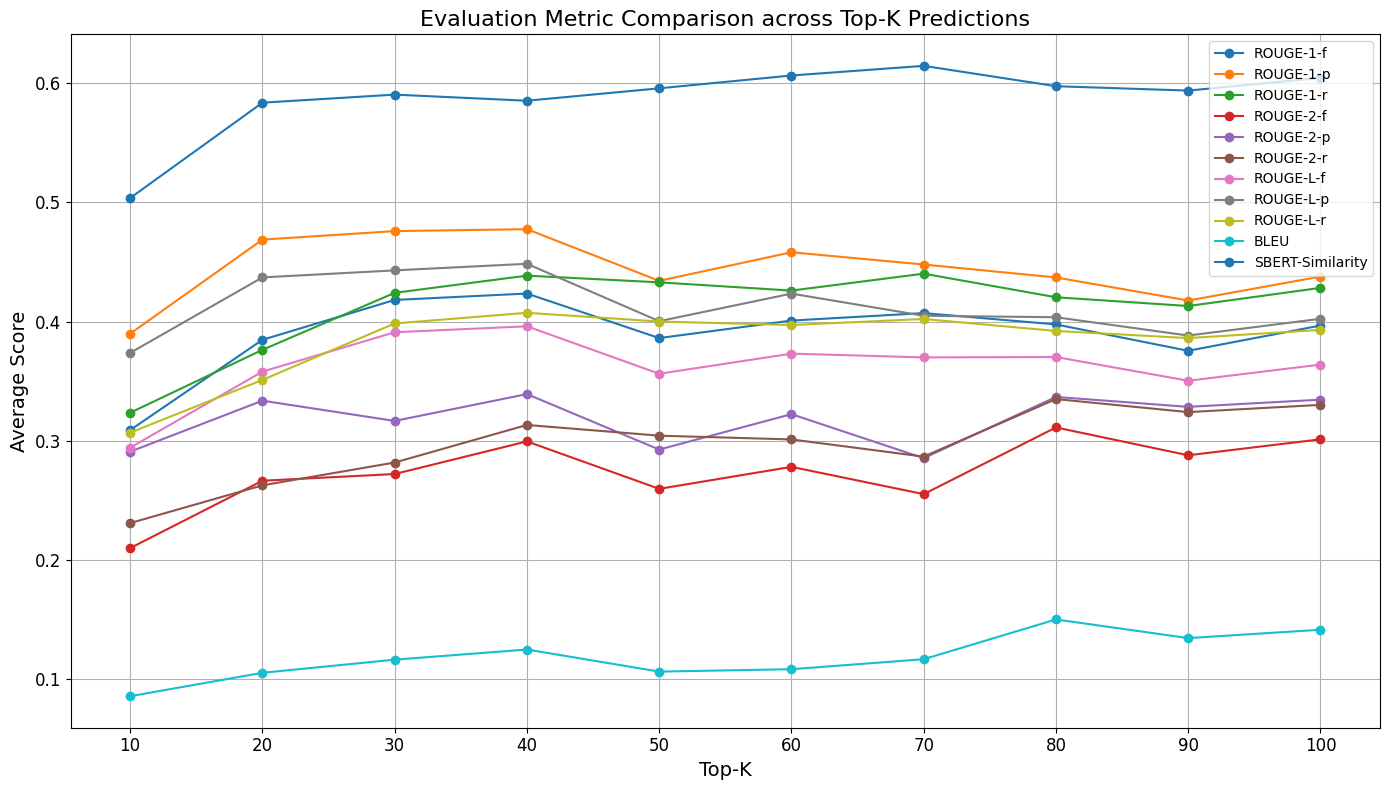

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util

# Initialization
rouge = Rouge()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
smoothing = SmoothingFunction().method1

# Configuration
base_path = "../data/MSE-KG/Abtest/"
top_k_list = list(range(10, 101, 10))
results = {}

# Batch processing
for top_k in top_k_list:
    file_name = f"Predicted_Answers_Contexts_Factual_Senetence_top{top_k}.xlsx"
    file_path = os.path.join(base_path, file_name)
    
    if not os.path.exists(file_path):
        continue

    df = pd.read_excel(file_path)

    # Initialize metric columns
    for metric in [
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]:
        df[metric] = 0.0

    for i, row in df.iterrows():
        generated = str(row["Answer"])
        ground_truth = str(row["Ground Truth"])

        try:
            rouge_scores = rouge.get_scores(generated, ground_truth)[0]
            df.at[i, "ROUGE-1-f"] = rouge_scores["rouge-1"]["f"]
            df.at[i, "ROUGE-1-p"] = rouge_scores["rouge-1"]["p"]
            df.at[i, "ROUGE-1-r"] = rouge_scores["rouge-1"]["r"]
            df.at[i, "ROUGE-2-f"] = rouge_scores["rouge-2"]["f"]
            df.at[i, "ROUGE-2-p"] = rouge_scores["rouge-2"]["p"]
            df.at[i, "ROUGE-2-r"] = rouge_scores["rouge-2"]["r"]
            df.at[i, "ROUGE-L-f"] = rouge_scores["rouge-l"]["f"]
            df.at[i, "ROUGE-L-p"] = rouge_scores["rouge-l"]["p"]
            df.at[i, "ROUGE-L-r"] = rouge_scores["rouge-l"]["r"]
        except:
            continue

        try:
            bleu = sentence_bleu([ground_truth.split()], generated.split(), smoothing_function=smoothing)
            df.at[i, "BLEU"] = bleu
        except:
            df.at[i, "BLEU"] = 0.0

        try:
            emb_gt = sbert_model.encode(ground_truth, convert_to_tensor=True, show_progress_bar=False)
            emb_gen = sbert_model.encode(generated, convert_to_tensor=True, show_progress_bar=False)
            sim = util.pytorch_cos_sim(emb_gt, emb_gen).item()
            df.at[i, "SBERT-Similarity"] = sim
        except:
            df.at[i, "SBERT-Similarity"] = 0.0

    # Save evaluated results for each file
    evaluated_file = os.path.join(base_path, f"Evaluated_Predicted_Answers_Contexts_Factual_Senetence_top{top_k}.xlsx")
    df.to_excel(evaluated_file, index=False)

    # Calculate averages for summary
    avg_scores = df[[
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]].mean()
    results[top_k] = avg_scores.to_dict()

    # Plot for current topK
    plt.figure(figsize=(12, 6))
    avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top-{top_k} Evaluation Metrics", fontsize=16)
    plt.ylabel("Average Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    fig_path = os.path.join(base_path, f"Top{top_k}_Evaluation_BarChart_NEW.png")
    plt.savefig(fig_path)
    plt.close()

# Create summary table of averages
result_df = pd.DataFrame(results).T
result_df.index.name = "Top-K"
result_df.to_excel("../data/MSE-KG/Abtest/Evaluation_Comparison_Averages_Sentence_denosing.xlsx")

# Plot comparison across all Top-K values
plt.figure(figsize=(14, 8))
for metric in result_df.columns:
    plt.plot(result_df.index, result_df[metric], marker='o', label=metric)

plt.title("Evaluation Metric Comparison across Top-K Predictions", fontsize=16)
plt.xlabel("Top-K", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.xticks(result_df.index, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/MSE-KG/Abtest/Evaluation_Comparison_Averages_Sentence_denosing.png")
plt.show()

2025-05-25 22:39:02,378 - INFO - Use pytorch device_name: cpu
2025-05-25 22:39:02,393 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2


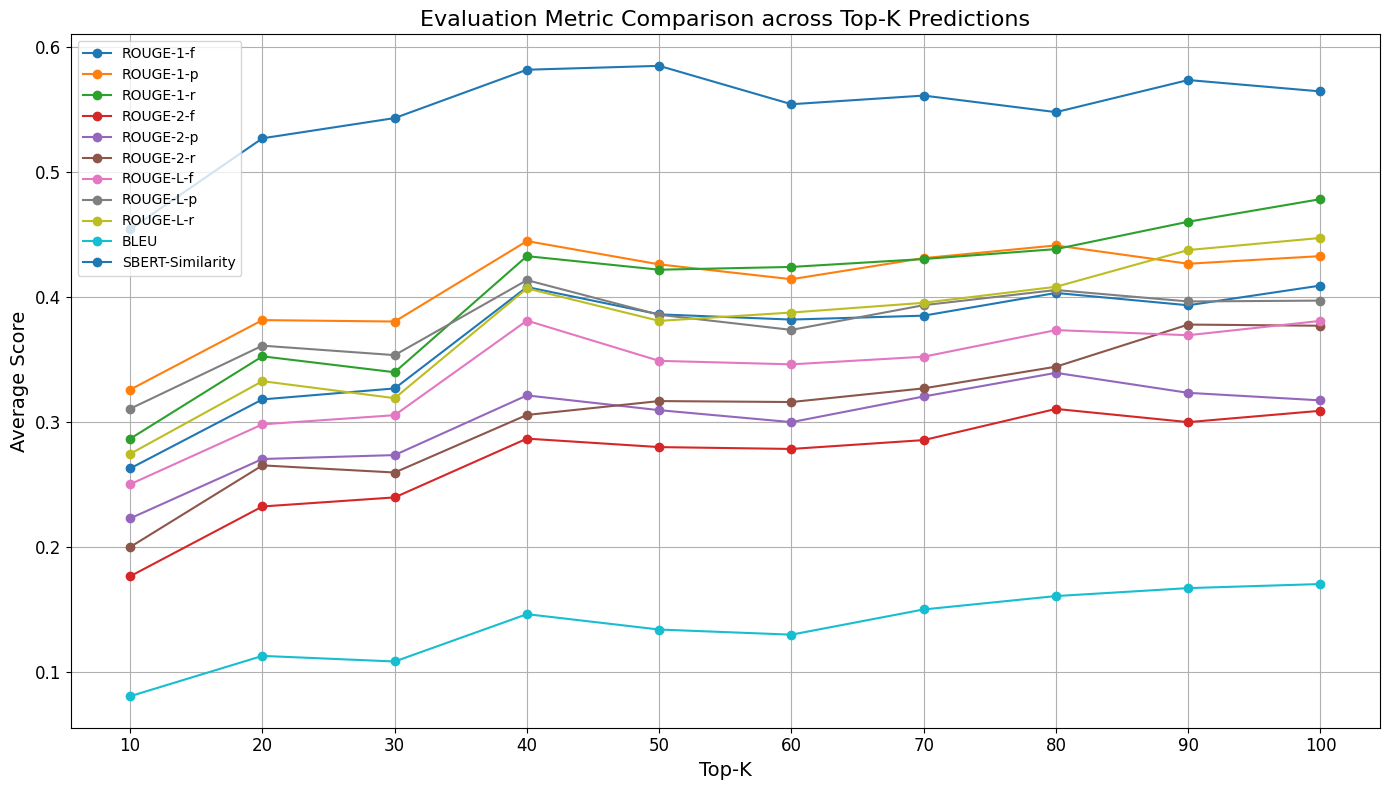

In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util

# Initialization
rouge = Rouge()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
smoothing = SmoothingFunction().method1

# Configuration
base_path = "../data/MSE-KG/Abtest2/"
top_k_list = list(range(10, 101, 10))
results = {}

# Batch processing
for top_k in top_k_list:
    file_name = f"Predicted_Answers_Contexts_Factual_Senetence_top{top_k}.xlsx"
    file_path = os.path.join(base_path, file_name)
    
    if not os.path.exists(file_path):
        continue

    df = pd.read_excel(file_path)

    # Initialize metric columns
    for metric in [
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]:
        df[metric] = 0.0

    for i, row in df.iterrows():
        generated = str(row["Answer"])
        ground_truth = str(row["Ground Truth"])

        try:
            rouge_scores = rouge.get_scores(generated, ground_truth)[0]
            df.at[i, "ROUGE-1-f"] = rouge_scores["rouge-1"]["f"]
            df.at[i, "ROUGE-1-p"] = rouge_scores["rouge-1"]["p"]
            df.at[i, "ROUGE-1-r"] = rouge_scores["rouge-1"]["r"]
            df.at[i, "ROUGE-2-f"] = rouge_scores["rouge-2"]["f"]
            df.at[i, "ROUGE-2-p"] = rouge_scores["rouge-2"]["p"]
            df.at[i, "ROUGE-2-r"] = rouge_scores["rouge-2"]["r"]
            df.at[i, "ROUGE-L-f"] = rouge_scores["rouge-l"]["f"]
            df.at[i, "ROUGE-L-p"] = rouge_scores["rouge-l"]["p"]
            df.at[i, "ROUGE-L-r"] = rouge_scores["rouge-l"]["r"]
        except:
            continue

        try:
            bleu = sentence_bleu([ground_truth.split()], generated.split(), smoothing_function=smoothing)
            df.at[i, "BLEU"] = bleu
        except:
            df.at[i, "BLEU"] = 0.0

        try:
            emb_gt = sbert_model.encode(ground_truth, convert_to_tensor=True, show_progress_bar=False)
            emb_gen = sbert_model.encode(generated, convert_to_tensor=True, show_progress_bar=False)
            sim = util.pytorch_cos_sim(emb_gt, emb_gen).item()
            df.at[i, "SBERT-Similarity"] = sim
        except:
            df.at[i, "SBERT-Similarity"] = 0.0

    # Save evaluated results for each file
    evaluated_file = os.path.join(base_path, f"Evaluated_Predicted_Answers_Contexts_Factual_Senetence_top{top_k}.xlsx")
    df.to_excel(evaluated_file, index=False)

    # Calculate averages for summary
    avg_scores = df[[
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]].mean()
    results[top_k] = avg_scores.to_dict()

    # Plot for current topK
    plt.figure(figsize=(12, 6))
    avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top-{top_k} Evaluation Metrics", fontsize=16)
    plt.ylabel("Average Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    fig_path = os.path.join(base_path, f"Top{top_k}_Evaluation_BarChart_NEW.png")
    plt.savefig(fig_path)
    plt.close()

# Create summary table of averages
result_df = pd.DataFrame(results).T
result_df.index.name = "Top-K"
result_df.to_excel("../data/MSE-KG/Abtest2/Evaluated_Predicted_Answers_Contexts_Factual_Senetence_top.xlsx")

# Plot comparison across all Top-K values
plt.figure(figsize=(14, 8))
for metric in result_df.columns:
    plt.plot(result_df.index, result_df[metric], marker='o', label=metric)

plt.title("Evaluation Metric Comparison across Top-K Predictions", fontsize=16)
plt.xlabel("Top-K", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.xticks(result_df.index, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/MSE-KG/Abtest2/Evaluated_Predicted_Answers_Contexts_Factual_Senetence_top.png")
plt.show()